In [1]:
%matplotlib inline
import tensorflow as tf
# sa = tf.Session()
# sa.close()
# import tensorflow as tf
# tf.Graph.as_default
# from tensorflow.python.client import device_lib
# local_device_protos = device_lib.list_local_devices()
# gpuname = [x.name for x in local_device_protos if x.device_type == 'GPU']
# tf.device(gpuname)
# sess = tf.Session(config=tf.ConfigProto(device_count={'GPU': 4}))
# os.environ["CUDA_VISIBLE_DEVICES"]="4"
import keras
from keras.models import Sequential
from keras.utils import multi_gpu_model
from keras.layers import Flatten, Dropout, Conv2D, MaxPooling2D, ZeroPadding2D, BatchNormalization, Dense, Activation
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import json
from pycocotools.coco import COCO
import numpy as np
import pandas as pd
import skimage.io as io
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import pylab
import copy
import os
import ast
import sys
import cv2
import matplotlib.patches as patches
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.
/shared/centos7/python/3.6.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [133]:
df_train = pd.read_csv('final_train_path_bbox_category_after_augment_after_resize_100.csv', low_memory=False)
df_val = pd.read_csv('final_val_path_bbox_category_after_augment_after_resize_100.csv', low_memory=False)
df_train_old = pd.read_csv('final_train_path_bbox_category_for_augment_after_resize_100.csv', low_memory=False)
df_val_old = pd.read_csv('final_val_path_bbox_category_for_augment_after_resize_100.csv', low_memory=False)
categories = pd.read_csv('categories.csv', index_col=['id'])
df_train.bboxes = df_train.bboxes.apply(lambda x : ast.literal_eval(x))
df_train_old.bboxes = df_train_old.bboxes.apply(lambda x : ast.literal_eval(x))
df_val.bboxes = df_val.bboxes.apply(lambda x : ast.literal_eval(x))
df_val_old.bboxes = df_val_old.bboxes.apply(lambda x : ast.literal_eval(x))
df_train.category_ids = df_train.category_ids.apply(lambda x : ast.literal_eval(x))
df_train_old.category_ids = df_train_old.category_ids.apply(lambda x : ast.literal_eval(x))
df_val.category_ids = df_val.category_ids.apply(lambda x : ast.literal_eval(x))
df_val_old.category_ids = df_val_old.category_ids.apply(lambda x : ast.literal_eval(x))

In [111]:
df_train.head()

,filepath,bboxes,category_ids
0,data/coco/train2017/augmented/000000457868.jpg,"[{'x1': 47.2890625, 'y1': 48.07472527472527, '...","[28, 28, 28, 28, 1, 1, 1, 27, 31, 8, 1, 3, 1]"
1,data/coco/train2017/augmented/000000372220.jpg,"[{'x1': 16.675, 'y1': 92.25974025974027, 'x2':...","[77, 1, 1, 31, 1]"
2,data/coco/train2017/augmented/000000211935.jpg,"[{'x1': 88.63380281690142, 'y1': 93.2296875, '...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3]"
3,data/coco/train2017/augmented/000000513983.jpg,"[{'x1': 4.302083333333334, 'y1': 12.0968749999...","[19, 61]"
4,data/coco/train2017/augmented/000000467951.jpg,"[{'x1': 19.6390625, 'y1': 51.22291666666668, '...","[86, 86, 67, 86]"


In [112]:
df_val.head()

,filepath,bboxes,category_ids
0,data/coco/val2017/augmented/000000217219.jpg,"[{'x1': 0.1265625, 'y1': 1.5571030640668369, '...",[65]
1,data/coco/val2017/augmented/000000405972.jpg,"[{'x1': 4.143192488262912, 'y1': 33.025, 'x2':...","[22, 22, 22]"
2,data/coco/val2017/augmented/000000047010.jpg,"[{'x1': 35.3875, 'y1': 36.310937500000016, 'x2...","[25, 25, 25, 21]"
3,data/coco/val2017/augmented/000000085823.jpg,"[{'x1': 19.39344262295082, 'y1': 38.2296875000...","[24, 24, 24]"
4,data/coco/val2017/augmented/000000225184.jpg,"[{'x1': 48.59956236323851, 'y1': 55.19375, 'x2...","[18, 20, 20, 20]"


In [113]:
df_train_old.head()

,filepath,bboxes,category_ids
0,data/coco/train2017/000000457868.jpg,"[{'x1': 47.2890625, 'y1': 15.296703296703297, ...","[28, 28, 28, 28, 1, 1, 1, 27, 31, 8, 1, 3, 1]"
1,data/coco/train2017/000000372220.jpg,"[{'x1': 92.25974025974027, 'y1': 78.7234375, '...","[77, 1, 1, 31, 1]"
2,data/coco/train2017/000000211935.jpg,"[{'x1': 93.2296875, 'y1': 88.63380281690142, '...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3]"
3,data/coco/train2017/000000513983.jpg,"[{'x1': 24.8390625, 'y1': 4.302083333333334, '...","[19, 61]"
4,data/coco/train2017/000000467951.jpg,"[{'x1': 19.6390625, 'y1': 51.22291666666668, '...","[86, 86, 67, 86]"


In [114]:
df_val_old.head()

,filepath,bboxes,category_ids
0,data/coco/val2017/000000217219.jpg,"[{'x1': 0.1265625, 'y1': 0.6880222841225628, '...",[65]
1,data/coco/val2017/000000405972.jpg,"[{'x1': 17.884375000000002, 'y1': 4.1431924882...","[22, 22, 22]"
2,data/coco/val2017/000000047010.jpg,"[{'x1': 47.309374999999996, 'y1': 41.708333333...","[25, 25, 25, 21]"
3,data/coco/val2017/000000085823.jpg,"[{'x1': 23.3890625, 'y1': 0.15690866510538642,...","[24, 24, 24]"
4,data/coco/val2017/000000225184.jpg,"[{'x1': 42.155361050328224, 'y1': 55.19375, 'x...","[18, 20, 20, 20]"


In [134]:
categories.head()

,name,supercategory
id,,
1,person,person
2,bicycle,vehicle
3,car,vehicle
4,motorcycle,vehicle
5,airplane,vehicle


In [116]:
df_val_final = pd.concat([df_val_old, df_val]).reset_index(drop=True)
df_val_final.head()

,filepath,bboxes,category_ids
0,data/coco/val2017/000000217219.jpg,"[{'x1': 0.1265625, 'y1': 0.6880222841225628, '...",[65]
1,data/coco/val2017/000000405972.jpg,"[{'x1': 17.884375000000002, 'y1': 4.1431924882...","[22, 22, 22]"
2,data/coco/val2017/000000047010.jpg,"[{'x1': 47.309374999999996, 'y1': 41.708333333...","[25, 25, 25, 21]"
3,data/coco/val2017/000000085823.jpg,"[{'x1': 23.3890625, 'y1': 0.15690866510538642,...","[24, 24, 24]"
4,data/coco/val2017/000000225184.jpg,"[{'x1': 42.155361050328224, 'y1': 55.19375, 'x...","[18, 20, 20, 20]"


In [117]:
df_train_final = pd.concat([df_train_old, df_train]).reset_index(drop=True)
df_train_final.head()

,filepath,bboxes,category_ids
0,data/coco/train2017/000000457868.jpg,"[{'x1': 47.2890625, 'y1': 15.296703296703297, ...","[28, 28, 28, 28, 1, 1, 1, 27, 31, 8, 1, 3, 1]"
1,data/coco/train2017/000000372220.jpg,"[{'x1': 92.25974025974027, 'y1': 78.7234375, '...","[77, 1, 1, 31, 1]"
2,data/coco/train2017/000000211935.jpg,"[{'x1': 93.2296875, 'y1': 88.63380281690142, '...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3]"
3,data/coco/train2017/000000513983.jpg,"[{'x1': 24.8390625, 'y1': 4.302083333333334, '...","[19, 61]"
4,data/coco/train2017/000000467951.jpg,"[{'x1': 19.6390625, 'y1': 51.22291666666668, '...","[86, 86, 67, 86]"


In [44]:
X_train = np.empty((len(df_train_final), 100, 100, 3), dtype=np.single)
for index, row in df_train_final.iterrows():
    im = cv2.imread(row['filepath'])
    X_train[index, ...] = im/255.

In [45]:
X_train

array([[[[1.        , 1.        , 0.9490196 ],
         [0.8980392 , 0.8627451 , 0.80784315],
         [0.54509807, 0.49411765, 0.4392157 ],
         ...,
         [0.72156864, 0.73333335, 0.7254902 ],
         [0.72156864, 0.73333335, 0.7254902 ],
         [0.6862745 , 0.69803923, 0.6901961 ]],

        [[0.99215686, 0.95686275, 0.90588236],
         [0.5764706 , 0.5411765 , 0.49019608],
         [0.5764706 , 0.5294118 , 0.48235294],
         ...,
         [0.6745098 , 0.6862745 , 0.6784314 ],
         [0.74509805, 0.75686276, 0.7490196 ],
         [0.76862746, 0.78039217, 0.77254903]],

        [[0.654902  , 0.61960787, 0.5803922 ],
         [0.5058824 , 0.47058824, 0.43137255],
         [0.43529412, 0.39607844, 0.35686275],
         ...,
         [0.8156863 , 0.827451  , 0.81960785],
         [0.69411767, 0.69803923, 0.6901961 ],
         [0.75686276, 0.7607843 , 0.7529412 ]],

        ...,

        [[0.38039216, 0.70980394, 0.59607846],
         [0.3647059 , 0.6862745 , 0.57254905]

In [46]:
X_train.shape

(234532, 100, 100, 3)

In [47]:
X_val = np.empty((len(df_val_final), 100, 100, 3), dtype=np.single)
for index, row in df_val_final.iterrows():
    im = cv2.imread(row['filepath'])
    X_val[index, ...] = im/255.

In [48]:
X_val.shape

(9904, 100, 100, 3)

In [49]:
X_val

array([[[[0.5882353 , 0.5411765 , 0.44705883],
         [0.5882353 , 0.5411765 , 0.44705883],
         [0.5882353 , 0.5411765 , 0.44705883],
         ...,
         [0.6862745 , 0.6156863 , 0.54901963],
         [0.49019608, 0.41960785, 0.3529412 ],
         [0.30980393, 0.23921569, 0.17254902]],

        [[0.58431375, 0.5372549 , 0.44313726],
         [0.58431375, 0.5372549 , 0.44313726],
         [0.58431375, 0.5372549 , 0.44313726],
         ...,
         [0.73333335, 0.65882355, 0.5764706 ],
         [0.7294118 , 0.654902  , 0.57254905],
         [0.56078434, 0.4862745 , 0.40392157]],

        [[0.58431375, 0.5372549 , 0.44313726],
         [0.58431375, 0.5372549 , 0.44313726],
         [0.5803922 , 0.53333336, 0.4392157 ],
         ...,
         [0.75686276, 0.6862745 , 0.57254905],
         [0.78039217, 0.7058824 , 0.6       ],
         [0.7607843 , 0.6862745 , 0.5803922 ]],

        ...,

        [[0.654902  , 0.68235296, 0.7490196 ],
         [0.5921569 , 0.64705884, 0.72156864]

In [50]:
np.save('/scratch/davda.g/X_val_new', X_val)
np.save('/scratch/davda.g/X_train_new', X_train)

In [122]:
bigl = []
for x in np.arange(len(df_val_final)):
    l = ['e','f']
    bigl.append(l)
df_val_final['labels'] = bigl
bigt = []
for x in np.arange(len(df_train_final)):
    l = ['e','f']
    bigt.append(l)
df_train_final['labels'] = bigt

In [136]:
for i, row in df_val_final.iterrows():
    ll = []
    l = row['category_ids']
    for x in l:
        ll.append(categories['name'][x])
    row['labels'] = ll

In [138]:
for i, row in df_train_final.iterrows():
    ll = []
    l = row['category_ids']
    for x in l:
        ll.append(categories['name'][x])
    row['labels'] = ll

In [139]:
df_val_final.to_csv('merged_val_after_resize_100.csv', index=False)
df_train_final.to_csv('merged_train_after_resize_100.csv', index=False)

In [5]:
df_train_final = pd.read_csv('merged_train_after_resize_100.csv', low_memory=False)
df_val_final = pd.read_csv('merged_val_after_resize_100.csv', low_memory=False)
df_train_final.bboxes = df_train_final.bboxes.apply(lambda x : ast.literal_eval(x))
df_train_final.category_ids = df_train_final.category_ids.apply(lambda x : ast.literal_eval(x))
df_train_final.labels = df_train_final.labels.apply(lambda x : ast.literal_eval(x))
df_val_final.bboxes = df_val_final.bboxes.apply(lambda x : ast.literal_eval(x))
df_val_final.category_ids = df_val_final.category_ids.apply(lambda x : ast.literal_eval(x))
df_val_final.labels = df_val_final.labels.apply(lambda x : ast.literal_eval(x))

In [6]:
df_final = pd.concat([df_train_final, df_val_final]).reset_index(drop=True)
df_final.shape

(244436, 4)

In [7]:
df_final.head()

,filepath,bboxes,category_ids,labels
0,data/coco/train2017/000000457868.jpg,"[{'x1': 47.2890625, 'y1': 15.296703296703297, ...","[28, 28, 28, 28, 1, 1, 1, 27, 31, 8, 1, 3, 1]","[umbrella, umbrella, umbrella, umbrella, perso..."
1,data/coco/train2017/000000372220.jpg,"[{'x1': 92.25974025974027, 'y1': 78.7234375, '...","[77, 1, 1, 31, 1]","[cell phone, person, person, handbag, person]"
2,data/coco/train2017/000000211935.jpg,"[{'x1': 93.2296875, 'y1': 88.63380281690142, '...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3]","[car, car, car, car, car, car, car, car, car, ..."
3,data/coco/train2017/000000513983.jpg,"[{'x1': 24.8390625, 'y1': 4.302083333333334, '...","[19, 61]","[horse, cake]"
4,data/coco/train2017/000000467951.jpg,"[{'x1': 19.6390625, 'y1': 51.22291666666668, '...","[86, 86, 67, 86]","[vase, vase, dining table, vase]"


In [8]:
X = pd.DataFrame(df_final[['filepath', 'bboxes', 'category_ids']])
y = df_final['labels']

In [9]:
x, x_test, y, y_test = train_test_split(X,y,test_size=0.2, train_size=0.8)
x, x_cv, y, y_cv = train_test_split(x,y,test_size = 0.25,train_size =0.75)

In [10]:
s = y.tolist()
mlb = MultiLabelBinarizer()
y_label = mlb.fit_transform(s)
y_cv_label = mlb.transform(y_cv)
y_test_label = mlb.transform(y_test)

In [8]:
print(x.shape)
print(x_cv.shape)
print(x_test.shape)

(146661, 3)
(48887, 3)
(48888, 3)


In [9]:
print(y.shape)
print(y_cv.shape)
print(y_test.shape)

(146661,)
(48887,)
(48888,)


In [10]:
print(y_label.shape)
print(y_cv_label.shape)
print(y_test_label.shape)

(146661, 80)
(48887, 80)
(48888, 80)


In [11]:
x = x.reset_index()
x_cv = x_cv.reset_index()
x_test = x_test.reset_index()
y = y.reset_index()
y_cv = y_cv.reset_index()
y_test = y_test.reset_index()

In [12]:
def loadX(data):
    x = np.empty((len(data), 100, 100, 3), dtype=np.single)
    for index, row in data.iterrows():
        im = cv2.imread(row['filepath'])
        x[index, ...] = im/255.
    return x
X_train = loadX(x)
X_val = loadX(x_cv)
X_test = loadX(x_test)

In [8]:
X_train = np.load('/scratch/davda.g/X_train_new.npy')
X_val = np.load('/scratch/davda.g/X_val_new.npy')

In [13]:
lbl_df = pd.DataFrame({'labels' : mlb.classes_})
lbl_df.head()

,labels
0,airplane
1,apple
2,backpack
3,banana
4,baseball bat


In [16]:
lbl_df.labels.tolist()

['airplane',
 'apple',
 'backpack',
 'banana',
 'baseball bat',
 'baseball glove',
 'bear',
 'bed',
 'bench',
 'bicycle',
 'bird',
 'boat',
 'book',
 'bottle',
 'bowl',
 'broccoli',
 'bus',
 'cake',
 'car',
 'carrot',
 'cat',
 'cell phone',
 'chair',
 'clock',
 'couch',
 'cow',
 'cup',
 'dining table',
 'dog',
 'donut',
 'elephant',
 'fire hydrant',
 'fork',
 'frisbee',
 'giraffe',
 'hair drier',
 'handbag',
 'horse',
 'hot dog',
 'keyboard',
 'kite',
 'knife',
 'laptop',
 'microwave',
 'motorcycle',
 'mouse',
 'orange',
 'oven',
 'parking meter',
 'person',
 'pizza',
 'potted plant',
 'refrigerator',
 'remote',
 'sandwich',
 'scissors',
 'sheep',
 'sink',
 'skateboard',
 'skis',
 'snowboard',
 'spoon',
 'sports ball',
 'stop sign',
 'suitcase',
 'surfboard',
 'teddy bear',
 'tennis racket',
 'tie',
 'toaster',
 'toilet',
 'toothbrush',
 'traffic light',
 'train',
 'truck',
 'tv',
 'umbrella',
 'vase',
 'wine glass',
 'zebra']

In [55]:
model2 = Sequential()
model2.add(ZeroPadding2D((1,1),input_shape=(100,100,3)))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(ZeroPadding2D((1,1)))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2,2), strides=(2,2)))
model2.add(Dropout(0.25))

model2.add(ZeroPadding2D((1,1)))
model2.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(ZeroPadding2D((1,1)))
model2.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2,2), strides=(2,2)))
model2.add(Dropout(0.25))

model2.add(ZeroPadding2D((1,1)))
model2.add(Conv2D(256, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(ZeroPadding2D((1,1)))
model2.add(Conv2D(256, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(ZeroPadding2D((1,1)))
model2.add(Conv2D(256, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2,2), strides=(2,2)))
model2.add(Dropout(0.25))

model2.add(ZeroPadding2D((1,1)))
model2.add(Conv2D(512, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(ZeroPadding2D((1,1)))
model2.add(Conv2D(512, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(ZeroPadding2D((1,1)))
model2.add(Conv2D(512, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2,2), strides=(2,2)))
model2.add(Dropout(0.25))

model2.add(ZeroPadding2D((1,1)))
model2.add(Conv2D(1024, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(ZeroPadding2D((1,1)))
model2.add(Conv2D(1024, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(ZeroPadding2D((1,1)))
model2.add(Conv2D(1024, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2,2), strides=(2,2)))
model2.add(Dropout(0.25))

model2.add(ZeroPadding2D((1,1)))
model2.add(Conv2D(2048, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(ZeroPadding2D((1,1)))
model2.add(Conv2D(2048, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(ZeroPadding2D((1,1)))
model2.add(Conv2D(2048, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2,2), strides=(2,2)))
model2.add(Dropout(0.25))

model2.add(Flatten())
model2.add(Dense(2048, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.25))
model2.add(Dense(4096, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(Dense(len(mlb.classes_)))
model2.add(Activation('sigmoid'))

In [56]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_17 (ZeroPaddi (None, 102, 102, 3)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 100, 100, 64)      1792      
_________________________________________________________________
batch_normalization_19 (Batc (None, 100, 100, 64)      256       
_________________________________________________________________
zero_padding2d_18 (ZeroPaddi (None, 102, 102, 64)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 100, 100, 64)      36928     
_________________________________________________________________
batch_normalization_20 (Batc (None, 100, 100, 64)      256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 50, 50, 64)        0         
__________

In [57]:
sgd = SGD(momentum=0.9, lr=0.1)
filepath="new_model2_weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=15, min_lr=0.001)
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_acc', patience=7)
callbacks_list = [reduce_lr, checkpoint, earlyStopping]

In [58]:
parallel_model2 = multi_gpu_model(model2, gpus=4)
parallel_model2.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
# model.compile(metrics=['accuracy'], optimizer=sgd, loss='binary_crossentropy')

In [59]:
history = parallel_model2.fit(X_train, y_label, batch_size=128, epochs=100,
                    validation_data = (X_val,y_cv_label),callbacks = callbacks_list)

Train on 146661 samples, validate on 48887 samples
Epoch 1/100
146661/146661 [==============================] - 746s 5ms/step - loss: 0.9516 - acc: 0.5246 - val_loss: 0.6012 - val_acc: 0.7055

Epoch 00001: val_acc improved from -inf to 0.70545, saving model to new_model2_weights.best.hdf5
Epoch 2/100
146661/146661 [==============================] - 725s 5ms/step - loss: 0.7523 - acc: 0.6098 - val_loss: 0.4738 - val_acc: 0.9410

Epoch 00002: val_acc improved from 0.70545 to 0.94104, saving model to new_model2_weights.best.hdf5
Epoch 3/100
146661/146661 [==============================] - 725s 5ms/step - loss: 0.5455 - acc: 0.7677 - val_loss: 0.3200 - val_acc: 0.9638

Epoch 00003: val_acc improved from 0.94104 to 0.96378, saving model to new_model2_weights.best.hdf5
Epoch 4/100
146661/146661 [==============================] - 726s 5ms/step - loss: 0.3607 - acc: 0.9064 - val_loss: 0.2084 - val_acc: 0.9652

Epoch 00004: val_acc improved from 0.96378 to 0.96518, saving model to new_model2_we

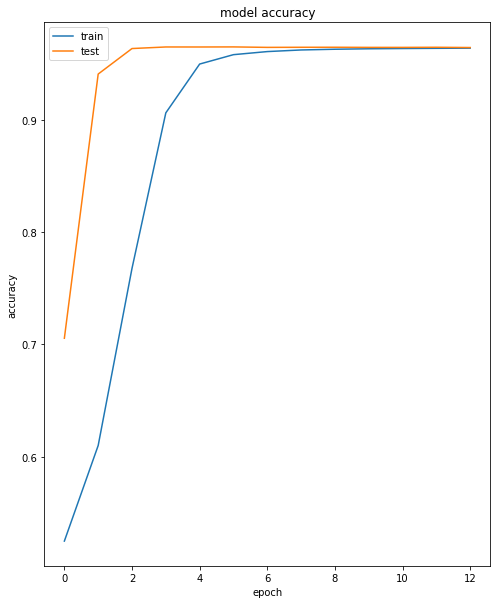

In [60]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

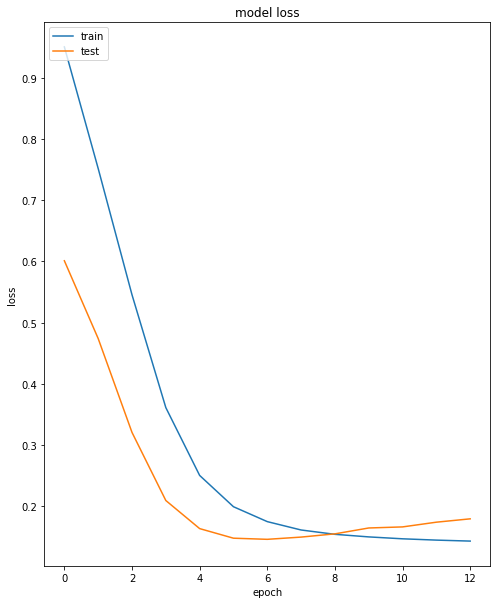

In [61]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [63]:
history.history

{'val_loss': [0.6012001159874536,
  0.47378497803916175,
  0.3199880112061696,
  0.208438730360938,
  0.1624226680021915,
  0.14670511914712164,
  0.14485617523566494,
  0.14852122584207778,
  0.1538147438433136,
  0.1634402086049465,
  0.1651907884843205,
  0.17293372127772388,
  0.17842279052996265],
 'val_acc': [0.7054546721695532,
  0.941036469677357,
  0.9637782081398041,
  0.9651765886825336,
  0.9651604813511798,
  0.9652348893575914,
  0.9648158101877314,
  0.9649078581184756,
  0.9649344493712363,
  0.9648119722287191,
  0.9648014893022062,
  0.9649053002005135,
  0.9646846371253772],
 'loss': [0.9515511722752167,
  0.7523441950775198,
  0.5454667358642576,
  0.3606607290184916,
  0.24952767826509828,
  0.198267805150995,
  0.17385462239610108,
  0.16014400121217295,
  0.15305052373088548,
  0.1488287431472409,
  0.14570746474450286,
  0.1435660171368049,
  0.14196163843930726],
 'acc': [0.5245752104594545,
  0.6098026208624093,
  0.767746538029683,
  0.906431497609672,
  0.94

In [2]:
from keras_applications.vgg16 import decode_predictions

In [3]:
loaded_model = keras.models.load_model('new_model2_weights.best.hdf5')

In [4]:
losses, accuracy = loaded_model.evaluate(X_test, y_test_label)
print('Test loss = ', losses)
print('Test accuracy = ', accuracy)

NameError: name 'X_test' is not defined

In [28]:
im = cv2.imread('bottle.jpg')
ii = cv2.resize(im, (100, 100), interpolation = cv2.INTER_AREA)
ii = ii/255.
te = np.empty((1, 100, 100, 3), dtype=np.single)
te[0, ...] = ii

In [29]:
prob = loaded_model.predict(te)
prob

array([[0.08850878, 0.05261724, 0.05861354, 0.05453866, 0.04510949,
        0.04366744, 0.07034545, 0.0661739 , 0.06767143, 0.07754312,
        0.0691452 , 0.07483573, 0.04793699, 0.0572314 , 0.04292942,
        0.04209706, 0.05308748, 0.04270681, 0.1253401 , 0.05895182,
        0.04309721, 0.05423816, 0.06001502, 0.08885117, 0.05950746,
        0.06960898, 0.04371737, 0.03526282, 0.0588081 , 0.0402077 ,
        0.0600788 , 0.06747535, 0.05764341, 0.06077177, 0.09958239,
        0.05449821, 0.04699751, 0.07267006, 0.04261304, 0.04749802,
        0.06358238, 0.03684271, 0.02810612, 0.04253966, 0.05074105,
        0.04485949, 0.04577222, 0.04210905, 0.04297922, 0.40395352,
        0.05036812, 0.03956103, 0.04843352, 0.04165561, 0.05414213,
        0.05040097, 0.04534728, 0.05554897, 0.0439729 , 0.06837147,
        0.05420785, 0.03931931, 0.05779868, 0.0580254 , 0.04127444,
        0.10330327, 0.0425377 , 0.04657927, 0.04166753, 0.04152409,
        0.05826681, 0.04914504, 0.05535776, 0.05

In [30]:
out = pd.DataFrame({'labels' : lbl_df.labels, 'prob' : prob[0]})
out.sort_values('prob', ascending=False)

,labels,prob
49,person,0.403954
18,car,0.125340
65,surfboard,0.103303
34,giraffe,0.099582
79,zebra,0.091058
23,clock,0.088851
0,airplane,0.088509
9,bicycle,0.077543
11,boat,0.074836
76,umbrella,0.073120


In [16]:
new_y_test = mlb.inverse_transform(y_test_label)
new_y_test[0]

('cake', 'knife', 'person', 'tie', 'vase')

In [17]:
y_test.loc[0]

index                                                125469
labels    [knife, cake, vase, tie, person, person, perso...
Name: 0, dtype: object

In [18]:
y_test_label[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [125]:
model3 = Sequential()
model3.add(ZeroPadding2D((1,1),input_shape=(100,100,3)))
model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(BatchNormalization())
model3.add(ZeroPadding2D((1,1)))
model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D((2,2), strides=(2,2)))
model3.add(Dropout(0.25))

model3.add(ZeroPadding2D((1,1)))
model3.add(Conv2D(128, (3, 3), activation='relu'))
model3.add(BatchNormalization())
model3.add(ZeroPadding2D((1,1)))
model3.add(Conv2D(128, (3, 3), activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D((2,2), strides=(2,2)))
model3.add(Dropout(0.25))

model3.add(ZeroPadding2D((1,1)))
model3.add(Conv2D(256, (3, 3), activation='relu'))
model3.add(BatchNormalization())
model3.add(ZeroPadding2D((1,1)))
model3.add(Conv2D(256, (3, 3), activation='relu'))
model3.add(BatchNormalization())
model3.add(ZeroPadding2D((1,1)))
model3.add(Conv2D(256, (3, 3), activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D((2,2), strides=(2,2)))
model3.add(Dropout(0.25))

model3.add(ZeroPadding2D((1,1)))
model3.add(Conv2D(512, (3, 3), activation='relu'))
model3.add(BatchNormalization())
model3.add(ZeroPadding2D((1,1)))
model3.add(Conv2D(512, (3, 3), activation='relu'))
model3.add(BatchNormalization())
model3.add(ZeroPadding2D((1,1)))
model3.add(Conv2D(512, (3, 3), activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D((2,2), strides=(2,2)))
model3.add(Dropout(0.25))

model3.add(ZeroPadding2D((1,1)))
model3.add(Conv2D(1024, (3, 3), activation='relu'))
model3.add(BatchNormalization())
model3.add(ZeroPadding2D((1,1)))
model3.add(Conv2D(1024, (3, 3), activation='relu'))
model3.add(BatchNormalization())
model3.add(ZeroPadding2D((1,1)))
model3.add(Conv2D(1024, (3, 3), activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D((2,2), strides=(2,2)))
model3.add(Dropout(0.25))

model3.add(ZeroPadding2D((1,1)))
model3.add(Conv2D(2048, (3, 3), activation='relu'))
model3.add(BatchNormalization())
model3.add(ZeroPadding2D((1,1)))
model3.add(Conv2D(2048, (3, 3), activation='relu'))
model3.add(BatchNormalization())
model3.add(ZeroPadding2D((1,1)))
model3.add(Conv2D(2048, (3, 3), activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D((2,2), strides=(2,2)))
model3.add(Dropout(0.25))

model3.add(Flatten())
model3.add(Dense(2048, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.25))
model3.add(Dense(4096, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))
model3.add(Dense(len(mlb.classes_)))
model3.add(Activation('sigmoid'))

In [126]:
sgd = SGD(momentum=0.9, lr=0.1)
filepath="new_model3_weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=15, min_lr=0.001)
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_acc', patience=7)
callbacks_list = [reduce_lr, checkpoint, earlyStopping]

In [127]:
parallel_model3 = multi_gpu_model(model3, gpus=4)
parallel_model3.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [ ]:
history2 = parallel_model3.fit(X_train, y_label, batch_size=128, epochs=100,
                    validation_data = (X_val,y_cv_label),callbacks = callbacks_list)

Train on 146661 samples, validate on 48887 samples
Epoch 1/100
146661/146661 [==============================] - 734s 5ms/step - loss: 11.7208 - acc: 0.0702 - val_loss: 11.1173 - val_acc: 0.1057

Epoch 00001: val_acc improved from -inf to 0.10565, saving model to new_model3_weights.best.hdf5
Epoch 2/100
146661/146661 [==============================] - 721s 5ms/step - loss: 10.5711 - acc: 0.1270 - val_loss: 11.5526 - val_acc: 0.1201

Epoch 00002: val_acc improved from 0.10565 to 0.12007, saving model to new_model3_weights.best.hdf5
Epoch 3/100
146661/146661 [==============================] - 724s 5ms/step - loss: 10.2381 - acc: 0.1325 - val_loss: 10.4151 - val_acc: 0.1281

Epoch 00003: val_acc improved from 0.12007 to 0.12807, saving model to new_model3_weights.best.hdf5
Epoch 4/100
146661/146661 [==============================] - 721s 5ms/step - loss: 10.1040 - acc: 0.1342 - val_loss: 11.5642 - val_acc: 0.1394

Epoch 00004: val_acc improved from 0.12807 to 0.13938, saving model to new_m

In [ ]:
plt.plot(history3.history['acc'])
plt.plot(history3.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()